In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import sampler
from torch.utils.data import DataLoader

import torchvision.datasets as dset
import torchvision.transforms as T

import timeit

import models
import solver
import views

# Basic Configuration

In [32]:
dtype = torch.FloatTensor
if torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor

print_every = 100

def reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()
    
    
def show_solver_training(solver):
    views.show_traning(solver.loss_history, solver.train_acc_history, solver.val_acc_history)

    
def show_mean_and_std_hist(parameters):
    paras = [w.data.cpu().numpy() for w in parameters]
    views.plot_mean_std_hist(paras)

    
def show_conv_layer_weights(conv_weights):
    conv_weights = conv_weights.data.cpu().numpy()
    conv_weights = conv_weights.transpose(0, 2, 3, 1)
    views.show_conv_weights(conv_weights)

    
def compare_solvers_tranings(solvers_with_labels):
    loss_train_val_acc_with_labels = {}
    for label, solver in solvers_with_labels.items():
        loss_train_val_acc_with_labels[label] = (solver.loss_history, solver.train_acc_history, solver.val_acc_history)
    
    views.compare_trainings(loss_train_val_acc_with_labels)


# Load cifar-10 dataset

In [4]:
class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset.
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from"""
    def __init__(self, num_samples, start=0):
        self.num_samples = num_samples
        self.start = start
        
    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))
    
    def __len__(self):
        return self.num_samples
    
NUM_TRAIN = 49000
NUM_VAL = 1000

NUM_TRAIN_SMALL = 64

cifar10_train_small = dset.CIFAR10('../cs231n/datasets/', train=True, download=True, transform=T.ToTensor())
loader_train_small = DataLoader(cifar10_train_small, batch_size=64, sampler=ChunkSampler(NUM_TRAIN_SMALL, 0))

cifar10_train = dset.CIFAR10('../cs231n/datasets/', train=True, download=True, transform=T.ToTensor())
loader_train = DataLoader(cifar10_train, batch_size=64, sampler=ChunkSampler(NUM_TRAIN, 0))

cifar10_val = dset.CIFAR10('../cs231n/datasets/', train=True, download=True, transform=T.ToTensor())
# cifar10_val = cifar10_train # can do this?
loader_val = DataLoader(cifar10_val, batch_size=64, sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))

cifar10_test = dset.CIFAR10('../cs231n/datasets/', train=False, download=True, transform=T.ToTensor())
loader_test = DataLoader(cifar10_test, batch_size=64)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


## 1. Train example model

In [5]:
torch.cuda.random.manual_seed(12345)

# model
example_model = models.ExampleNet().type(dtype)
example_loss_fn = nn.CrossEntropyLoss().type(dtype)

#example_optimizer = optim.Adam(example_model.parameters(), lr=1e-3)
example_optimizer = optim.SGD(example_model.parameters(), lr=3e-3, momentum=0.9, weight_decay=1e-5)
#example_optimizer = optim.RMSprop(example_model.parameters(), lr=5e-5, weight_decay=1e-2)

example_exp_lr_scheduler = None
#example_exp_lr_scheduler = lr_scheduler.StepLR(example_optimizer, step_size=3, gamma=0.5)

example_solver = solver.ClassificationSolver(loader_train=loader_train, loader_val=loader_val,
                                     model=example_model,
                                     loss_fn=example_loss_fn,
                                     optimizer=example_optimizer,
                                     scheduler=example_exp_lr_scheduler,
                                     dtype=dtype,
                                     num_epochs=5, verbose=True)

example_solver.train()

t = 0, loss = 2.3073
t = 100, loss = 1.6152
t = 200, loss = 1.2299
t = 300, loss = 1.4239
t = 400, loss = 1.3907
t = 500, loss = 1.5351
t = 600, loss = 1.4290
t = 700, loss = 1.2424
(Epoch 0 / 5) train acc: 0.492188; val acc: 0.486000
t = 0, loss = 1.2827
t = 100, loss = 1.3359
t = 200, loss = 0.8527
t = 300, loss = 1.1362
t = 400, loss = 1.1338
t = 500, loss = 1.5515
t = 600, loss = 1.1432
t = 700, loss = 1.1684
(Epoch 1 / 5) train acc: 0.525391; val acc: 0.496000
t = 0, loss = 1.0933
t = 100, loss = 1.1273
t = 200, loss = 0.7983
t = 300, loss = 1.0311
t = 400, loss = 1.1229
t = 500, loss = 1.3245
t = 600, loss = 1.0699
t = 700, loss = 1.0843
(Epoch 2 / 5) train acc: 0.596680; val acc: 0.552000
t = 0, loss = 1.0053
t = 100, loss = 0.9938
t = 200, loss = 0.8163
t = 300, loss = 0.9600
t = 400, loss = 1.0536
t = 500, loss = 1.2906
t = 600, loss = 1.0025
t = 700, loss = 1.0939
(Epoch 3 / 5) train acc: 0.632812; val acc: 0.573000
t = 0, loss = 0.9145
t = 100, loss = 0.8665
t = 200, loss = 

## 2. show training statistics

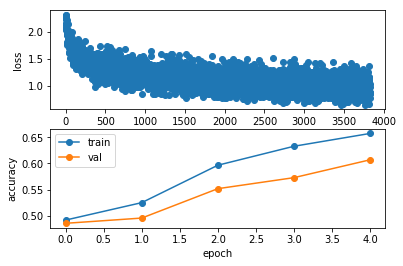

In [6]:
# loss, train_acc_histroy, val_acc_history
show_solver_training(example_solver)

weight index:  0
with size  (32, 3, 7, 7)
with mean: -0.004416, std: 0.079765


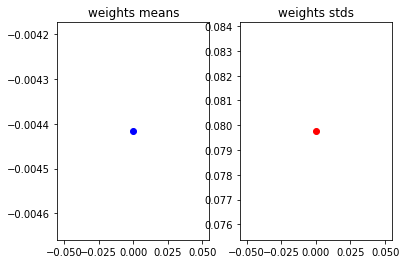

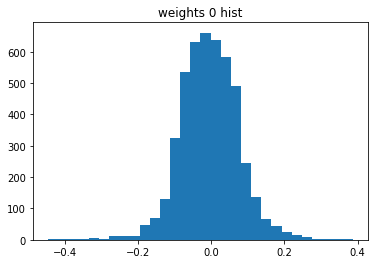

In [33]:
# plot weights mean and std
show_mean_and_std_hist(list(example_model.parameters())[0:1])

net.paras:  ExampleNet(
  (conv): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1))
  (relu): ReLU(inplace)
  (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (max_pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (fc1): Linear(in_features=5408, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)


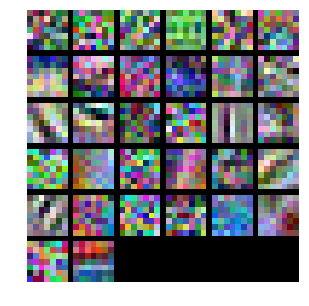

In [13]:
print('net.paras: ', example_model)

# view first conv layer(conv1) weights
show_conv_layer_weights(example_model.conv.weight)

# 2. Train second model

In [15]:
torch.cuda.random.manual_seed(12345)
#example_dropout_model.apply(reset)

# model
example_dropout_model = models.ExampleDropoutNet().type(dtype)
example_dropout_loss_fn = nn.CrossEntropyLoss().type(dtype)

#example_dropout_optimizer = optim.Adam(example_dropout_model.parameters(), lr=1e-3)
example_dropout_optimizer = optim.SGD(example_dropout_model.parameters(), lr=1e-3, momentum=0.9)
#example_dropout_optimizer = optim.SGD(example_dropout_model.parameters(), lr=5e-4, momentum=0.9, weight_decay=2e-4)
#example_dropout_optimizer = optim.RMSprop(example_dropout_model.parameters(), lr=1e-4)

#example_dropout_exp_lr_scheduler = None
example_dropout_exp_lr_scheduler = lr_scheduler.StepLR(example_dropout_optimizer, step_size=5, gamma=0.7)

example_dropout_solver = solver.ClassificationSolver(loader_train=loader_train, loader_val=loader_val,
                                     model=example_dropout_model,
                                     loss_fn=example_dropout_loss_fn,
                                     optimizer=example_dropout_optimizer,
                                     scheduler=example_dropout_exp_lr_scheduler,
                                     dtype=dtype,
                                     num_epochs=20, verbose=True)

example_dropout_solver.train()

t = 0, loss = 2.3169
t = 100, loss = 1.8289
t = 200, loss = 1.5381
t = 300, loss = 1.5870
t = 400, loss = 1.5274
t = 500, loss = 1.6429
t = 600, loss = 1.5287
t = 700, loss = 1.4523
(Epoch 0 / 20) train acc: 0.424805; val acc: 0.446000
t = 0, loss = 1.4238
t = 100, loss = 1.3586
t = 200, loss = 1.1539
t = 300, loss = 1.3562
t = 400, loss = 1.1567
t = 500, loss = 1.4199
t = 600, loss = 1.3657
t = 700, loss = 1.3631
(Epoch 1 / 20) train acc: 0.540039; val acc: 0.549000
t = 0, loss = 1.2244
t = 100, loss = 1.1526
t = 200, loss = 0.9285
t = 300, loss = 1.1293
t = 400, loss = 1.0255
t = 500, loss = 1.3141
t = 600, loss = 1.1957
t = 700, loss = 1.2773
(Epoch 2 / 20) train acc: 0.591797; val acc: 0.551000
t = 0, loss = 1.0958
t = 100, loss = 1.1159
t = 200, loss = 0.7721
t = 300, loss = 0.9831
t = 400, loss = 0.9772
t = 500, loss = 1.1496
t = 600, loss = 0.9936
t = 700, loss = 1.0484
(Epoch 3 / 20) train acc: 0.657227; val acc: 0.600000
t = 0, loss = 0.9908
t = 100, loss = 1.0906
t = 200, los

ExampleDropoutNet(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU(inplace)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(
    )
    (1): Linear(in_features=5408, out_features=1024, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=1024, out_features=10, bias=True)
  )
)


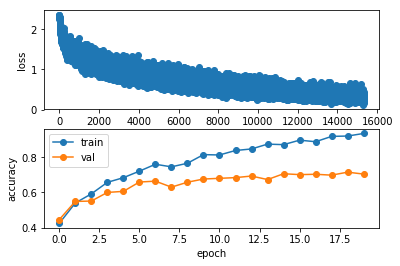

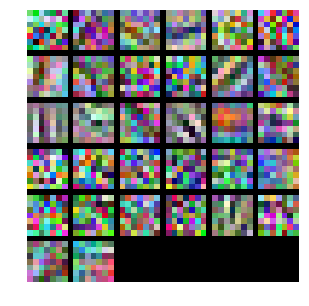

In [21]:
# print net structure
print(example_dropout_model)

# show loss, acc
show_solver_training(example_dropout_solver)

# show first conv layer weight
show_conv_layer_weights(example_dropout_model.features[0].weight)

# 3. Compare two models

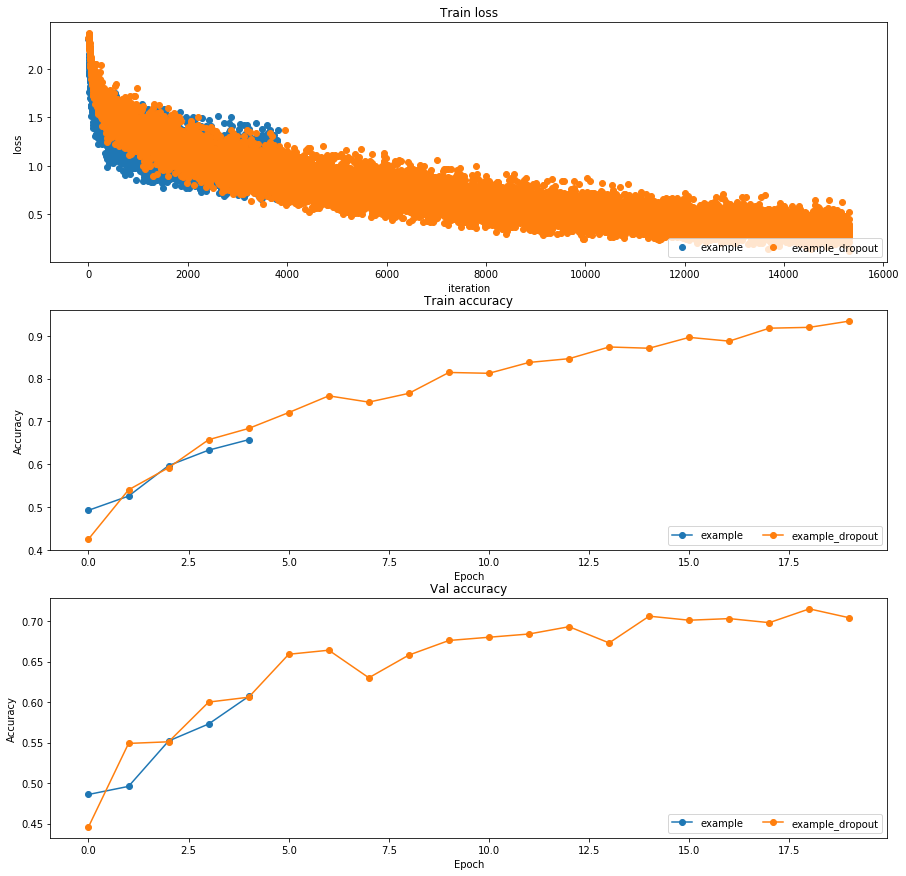

In [26]:
#
compare_solvers_tranings({'example': example_solver, 'example_dropout': example_dropout_solver})

# 3. thrid model

In [37]:
torch.cuda.random.manual_seed(12345)

# model
small_filter_model = models.SmallFilterNet().type(dtype)
small_filter_loss_fn = nn.CrossEntropyLoss().type(dtype)
#small_filter_optimizer = optim.SGD(small_filter_model.parameters(), lr=1e-3, momentum=0.9)

small_filter_optimizer = optim.Adam(small_filter_model.parameters(), lr=1e-4)
#small_filter_scheduler = lr_scheduler.StepLR(small_filter_optimizer, step_size=5, gamma=0.1)

small_filter_solver = solver.ClassificationSolver(loader_train=loader_train, loader_val=loader_val,
                                     model=small_filter_model,
                                     loss_fn=small_filter_loss_fn,
                                     optimizer=small_filter_optimizer,
                                     scheduler=None,
                                     dtype=dtype,
                                     num_epochs=20, verbose=True)

small_filter_solver.train()

t = 0, loss = 2.3230
t = 100, loss = 1.4625
t = 200, loss = 1.0782
t = 300, loss = 1.1579
t = 400, loss = 1.1065
t = 500, loss = 1.3602
t = 600, loss = 1.3047
t = 700, loss = 1.3422
(Epoch 0 / 20) train acc: 0.637695; val acc: 0.622000
t = 0, loss = 0.9779
t = 100, loss = 0.9723
t = 200, loss = 0.7816
t = 300, loss = 1.0072
t = 400, loss = 0.8780
t = 500, loss = 1.1755
t = 600, loss = 1.1201
t = 700, loss = 1.1773
(Epoch 1 / 20) train acc: 0.692383; val acc: 0.663000
t = 0, loss = 0.8609
t = 100, loss = 0.8459
t = 200, loss = 0.7135
t = 300, loss = 0.8988
t = 400, loss = 0.7683
t = 500, loss = 1.1053
t = 600, loss = 0.9873
t = 700, loss = 1.0647
(Epoch 2 / 20) train acc: 0.722656; val acc: 0.668000
t = 0, loss = 0.7523
t = 100, loss = 0.7643
t = 200, loss = 0.6635
t = 300, loss = 0.8032
t = 400, loss = 0.6979
t = 500, loss = 1.0395
t = 600, loss = 0.8656
t = 700, loss = 0.9698
(Epoch 3 / 20) train acc: 0.756836; val acc: 0.683000
t = 0, loss = 0.6599
t = 100, loss = 0.6982
t = 200, los

KeyboardInterrupt: 

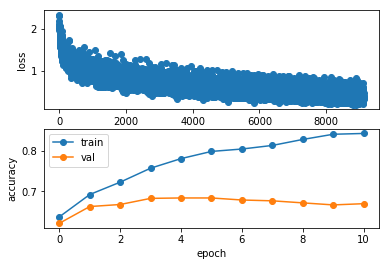

In [38]:
show_solver_training(small_filter_solver)

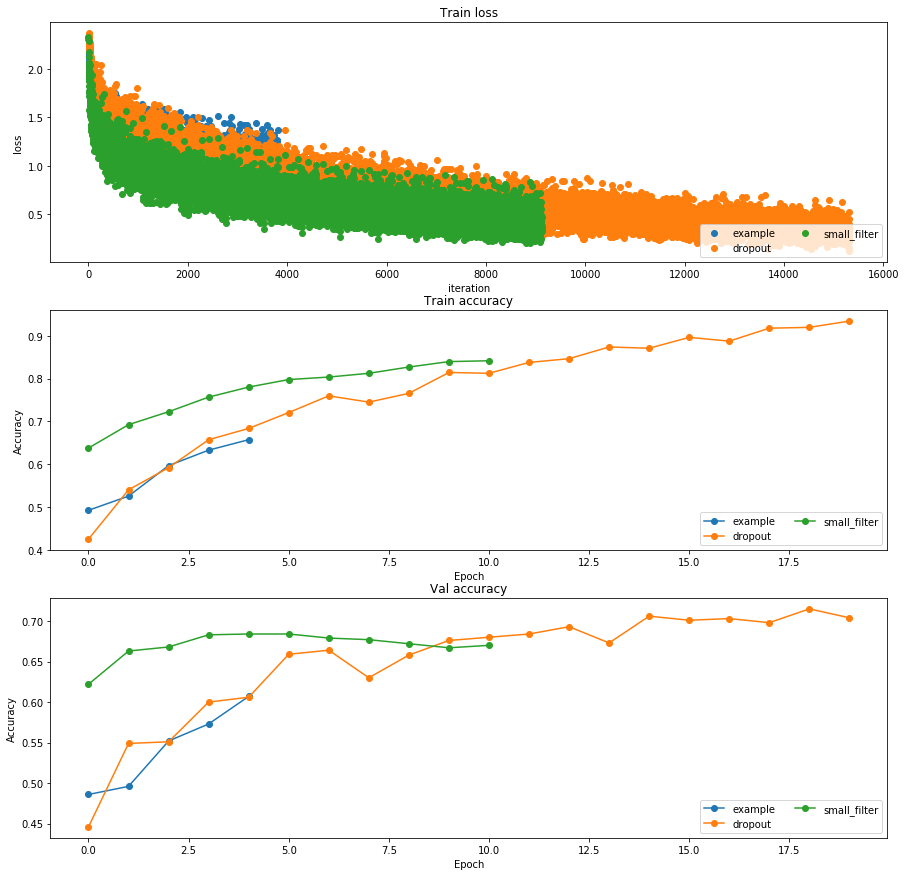

In [39]:
# compre three model trainings
compare_solvers_tranings({'example': example_solver,
                  'dropout': example_dropout_solver,
                  'small_filter': small_filter_solver})